## Ссылки
### Статьи
- https://paperswithcode.com/task/multi-armed-bandits

- https://github.com/kfoofw/bandit_simulations/blob/master/python/contextual_bandits/analysis/linUCB%20hybrid%20implementation%20and%20analysis.md
### Датасет
https://grouplens.org/datasets/movielens/latest/

In [265]:
!wget 'https://grouplens.org/datasets/movielens/latest/'

"wget" ­Ґ пў«пҐвбп ў­гваҐ­­Ґ© Ё«Ё ў­Ґи­Ґ©
Є®¬ ­¤®©, ЁбЇ®«­пҐ¬®© Їа®Ја ¬¬®© Ё«Ё Ї ЄҐв­л¬ д ©«®¬.


In [470]:
import pandas as pd
import numpy as np

from typing import Optional
from collections import defaultdict

from sklearn.utils import check_random_state

import matplotlib.pyplot as plt
import seaborn as sns

%matplotlib inline

%config InlineBackend.figure_format = 'retina'
plt.rcParams['font.size'] = 30
plt.rcParams['figure.figsize'] = (14, 8)

sns.set(style="darkgrid")

## Вычисление метрик

In [471]:
def calculate_pk(all_actual, all_predicted, k):
    assert len(all_actual) == len(all_predicted)
    pk = 0
    count = len(all_predicted)
    
    for actual, predicted in zip(all_actual, all_predicted):
        pk += len(set(actual[:k]).intersection(set(predicted[:k]))) 
    return pk / (k * count)

def calculate_user_apk(all_actual, all_predicted, k):
    apk = 0
    
    for i, predicted in enumerate(all_predicted[:k]):        
        apk += calculate_pk([all_actual], [all_predicted[:i+1]], i+1)
    
    return apk / k

def calculate_mapk(all_actual, all_predicted, k):
    assert len(all_actual) == len(all_predicted)
    mapk = 0
    count = len(all_predicted)
    
    for actual, predicted in zip(all_actual, all_predicted):
        mapk += calculate_user_apk(actual, predicted, k)
        
    return mapk / count

## Описание моделей

In [251]:
class TompsonSampling:
    def __init__(self, random_state: Optional[int] = None):
        self.random_state = random_state
        self.randomizer = check_random_state(self.random_state)
        
        if self.random_state is None:
            self.random_state = 1
            
        self.random_ = {} 
        self.beta_ = defaultdict(int)
        self.alpha_ = defaultdict(int)
        
    def update_params(self, item_name, reward):
        if item_name not in self.random_:
            self.random_[item_name] = check_random_state(self.randomizer.randint(1, 1000000))
        
        if reward == 0:
            self.beta_[item_name] += 1
        else:
            self.alpha_[item_name] += 1
            
        if self.beta_[item_name] == 0:
            self.beta_[item_name] = 1
        if self.alpha_[item_name] == 0:
            self.alpha_[item_name] = 1
            
    def select_action(self, n_items = 1):
        predicted_rewards = {
            key: sampling.beta(a=self.alpha_[key], b=self.beta_[key]) for key, sampling in self.random_.items()
        }
        
        return list({k: v for k, v in sorted(predicted_rewards.items(), key=lambda item: item[1], reverse=True)})[0:n_items]
    
    def execute_experiment(self, item_names, target, train_count):
        pred_item_and_target = []
        
        for i, (item_name, target) in enumerate(zip(item_names, target)):
            if i <= train_count:
                self.update_params(item_name, target)
                continue
    
            pred_item = self.select_action()
            self.update_params(item_name, target)
    
            pred_item_and_target.append((pred_item, item_name))
        
        return pred_item_and_target
    
    
class UCB1():
    def __init__(self):
        self.counts = defaultdict(int)
        self.values = defaultdict(float)
    
    def update_params(self, item_name, reward):
        self.counts[item_name] += 1
        n = self.counts[item_name]
        
        # Update average/mean value/reward for chosen arm
        value = self.values[item_name]
        self.values[item_name] = ((n - 1) / float(n)) * value + (1 / float(n)) * reward
        
    def select_action(self, n_items = 1):
        for arm, values in self.counts.items():
            if self.counts[arm] == 0:
                return arm
    
        ucb_values = defaultdict(float)
        total_counts = sum(self.counts.values())
        
        for arm, value in self.counts.items():
            bonus = np.sqrt((2 * np.log(total_counts)) / float(value))
            ucb_values[arm] = self.values[arm] + bonus + min(np.random.rand(3))
        
        return list({k: v for k, v in sorted(ucb_values.items(), key=lambda item: item[1], reverse=True)})[0:n_items]
    

class LinUCB():
    def __init__(self, n_features, batch_size = 10, alpha=0.001):
        self.A_inv_temp = defaultdict(lambda: np.eye(n_features))
        self.b_temp = defaultdict(lambda: np.zeros(n_features))
        
        self.A_inv = defaultdict(lambda: np.eye(n_features))
        self.b = defaultdict(lambda: np.zeros(n_features))
        
        self.action_counts = defaultdict(int)
        
        self.batch_size = batch_size
        self.n_trial = 0
        self.alpha = alpha
        
    
    def update_params(self, item_name, features, reward):    
        self.n_trial += 1
        self.action_counts[item_name] += 1
        
        context = np.array([features])
        
        self.A_inv_temp[item_name] -= (
            self.A_inv_temp[item_name]
            @ context.T
            @ context
            @ self.A_inv_temp[item_name]
            / (1 + context @ self.A_inv_temp[item_name] @ context.T)[0][0]
        )
        
        self.b_temp[item_name] += reward * context.flatten()
        if self.n_trial % self.batch_size == 0:
            self.A_inv, self.b = (
                self.A_inv_temp.copy(),
                self.b_temp.copy(),
            )

    
    def select_action(self, features, n_items=1):
        ucb_values = {}
        
        features = np.array(features)
        
        for arm, matrix in self.A_inv.items():
            theta_hat = matrix @ self.b[arm]
            sigma_hat = np.sqrt(features @ matrix @ features.T) 
            
            ucb_values[arm] = features @ theta_hat + self.alpha * sigma_hat
            
        return list({k: v for k, v in sorted(ucb_values.items(), key=lambda item: item[1], reverse=True)})[0:n_items]

## Подготовка данных

In [488]:
df_ratings = pd.read_csv('ml-latest-small/ratings.csv', index_col=False)
df_movies = pd.read_csv('ml-latest-small/movies.csv', index_col=False)
df_movies['splitted_genres'] = df_movies['genres'].apply(lambda genres: genres.split('|'))
df_movies

,movieId,title,genres,splitted_genres
0,1,Toy Story (1995),Adventure|Animation|Children|Comedy|Fantasy,"[Adventure, Animation, Children, Comedy, Fantasy]"
1,2,Jumanji (1995),Adventure|Children|Fantasy,"[Adventure, Children, Fantasy]"
2,3,Grumpier Old Men (1995),Comedy|Romance,"[Comedy, Romance]"
3,4,Waiting to Exhale (1995),Comedy|Drama|Romance,"[Comedy, Drama, Romance]"
4,5,Father of the Bride Part II (1995),Comedy,[Comedy]
...,...,...,...,...
9737,193581,Black Butler: Book of the Atlantic (2017),Action|Animation|Comedy|Fantasy,"[Action, Animation, Comedy, Fantasy]"
9738,193583,No Game No Life: Zero (2017),Animation|Comedy|Fantasy,"[Animation, Comedy, Fantasy]"
9739,193585,Flint (2017),Drama,[Drama]
9740,193587,Bungo Stray Dogs: Dead Apple (2018),Action|Animation,"[Action, Animation]"


In [489]:
df_ratings['target_v1'] = round((df_ratings['rating'] - df_ratings['rating'].min()) / (df_ratings['rating'].max() - df_ratings['rating'].min()))
df_ratings['target_v2'] = df_ratings['rating'].apply(lambda x: 1 if x >= 4 else 0)

In [490]:
df_ratings.groupby(['target_v2']).count()

,userId,movieId,rating,timestamp,target_v1
target_v2,,,,,
0,52256,52256,52256,52256,52256
1,48580,48580,48580,48580,48580


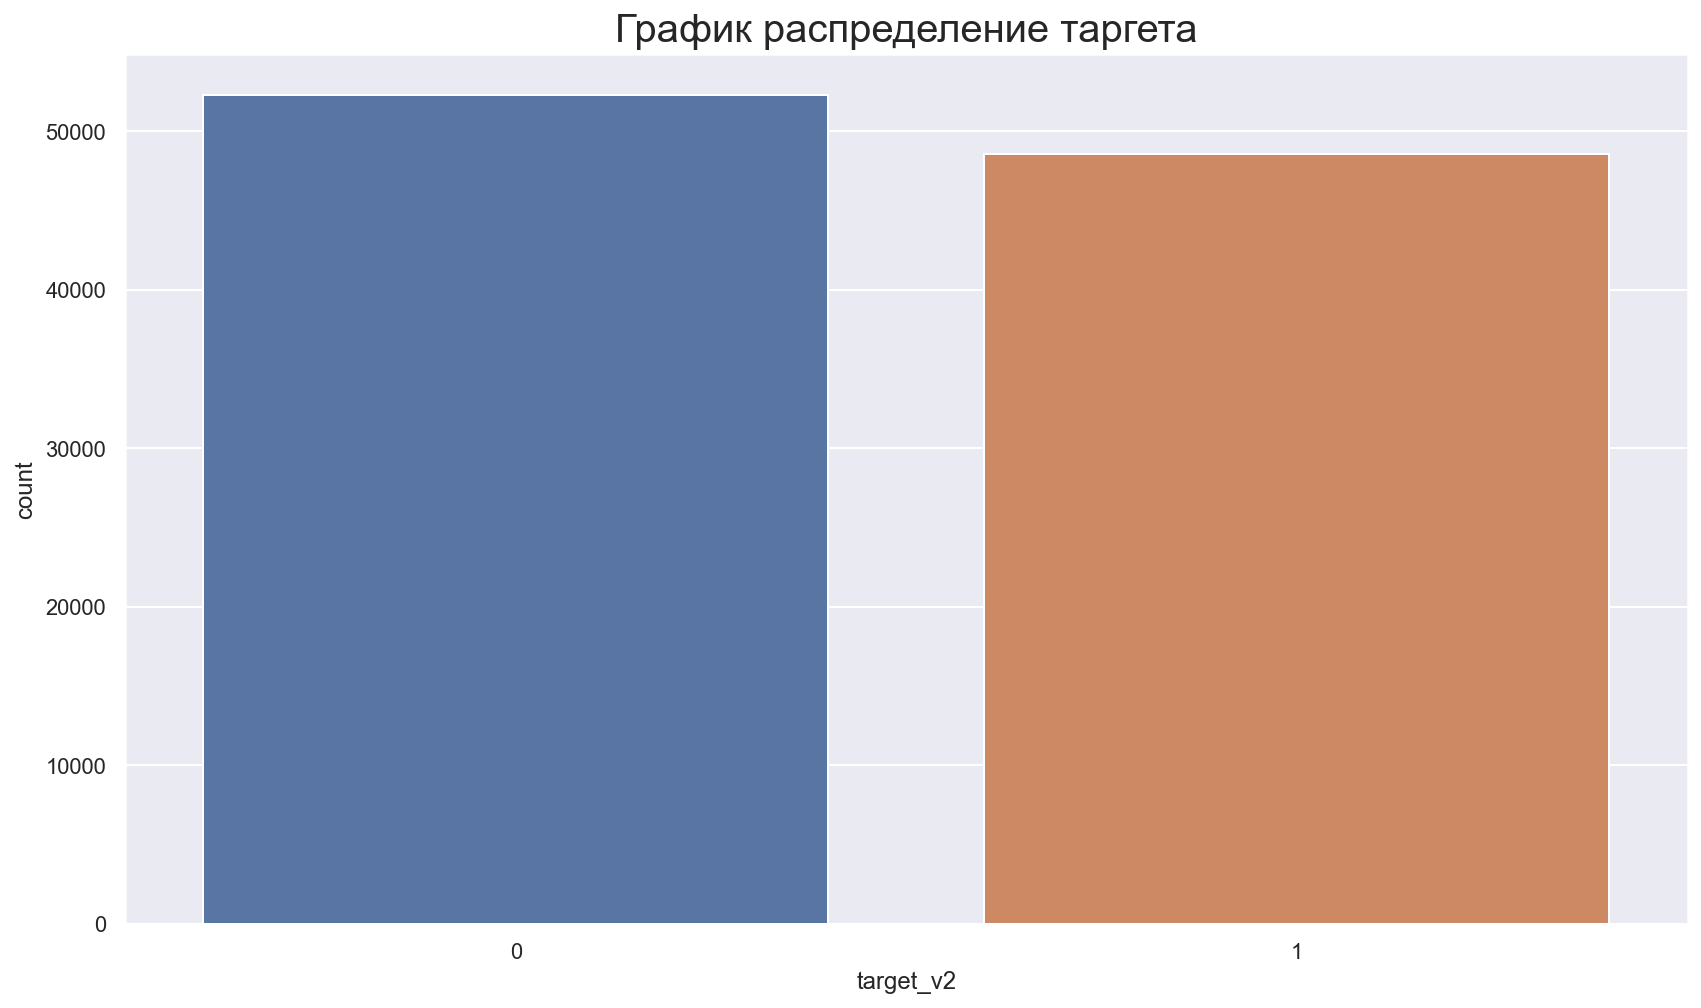

In [491]:
plt.title('График распределение таргета', fontsize=20)
ax = sns.countplot(x="target_v2", data=df_ratings)

## Признаки 
### Распределение жанров

In [500]:
class GenresDistributionTransformer():
    def __init__(self, movie_genres):
        self.movie_genres = movie_genres
        self.all_genre_list = {v for values in movie_genres.values() for v in values}
        
        self.user_n_genres = dict()
    
    def fit_transform(self, userId, movieId):
        if userId not in self.user_n_genres:
            self.user_n_genres[userId] = defaultdict(int)
            
        for genre in self.movie_genres[movieId]:
            self.user_n_genres[userId][genre] += 1
        
        total_count = sum(self.user_n_genres[userId].values())
        
        return [self.user_n_genres[userId][g] / total_count for g in self.all_genre_list]
    
    def get_last_dist(self, userId):
        if userId not in self.user_n_genres:
            self.user_n_genres[userId] = defaultdict(int)
        
        total_count = sum(self.user_n_genres[userId].values())
        
        total_count = 1 if total_count == 0 else total_count
        
        return [self.user_n_genres[userId][g] / total_count for g in self.all_genre_list]

In [535]:
user_genres_dist = []

movie_genres = {movieId: genres for movieId, genres in df_movies[['movieId', 'splitted_genres']].values}

transformer = GenresDistributionTransformer(movie_genres)

df_ratings = df_ratings.sort_values(['timestamp'])
for userId, movieId, target in df_ratings[['userId', 'movieId', 'target_v2']].values:
    if target == 0:
        user_genres_dist.append(transformer.get_last_dist(userId))
        continue
        
    user_genres_dist.append(transformer.fit_transform(userId, movieId))


## Добавление признаков

In [543]:
df = df_ratings[['userId', 'movieId', 'target_v2']].rename(columns={'target_v2': 'target'})
df['features'] = user_genres_dist
df

,userId,movieId,target,features
66719,429,595,1,"[0.16666666666666666, 0.0, 0.16666666666666666..."
66667,429,161,1,"[0.1111111111111111, 0.0, 0.1111111111111111, ..."
66705,429,343,0,"[0.1111111111111111, 0.0, 0.1111111111111111, ..."
66669,429,165,1,"[0.08333333333333333, 0.0, 0.08333333333333333..."
66714,429,468,0,"[0.08333333333333333, 0.0, 0.08333333333333333..."
...,...,...,...,...
81475,514,187031,0,"[0.04480651731160896, 0.038696537678207736, 0...."
81477,514,187595,0,"[0.04480651731160896, 0.038696537678207736, 0...."
81336,514,5247,0,"[0.04480651731160896, 0.038696537678207736, 0...."
81335,514,5246,0,"[0.04480651731160896, 0.038696537678207736, 0...."


## Разделение на подвыборки

In [544]:
separate_index = round(df.shape[0] * 0.7)
train_df = df.iloc[:separate_index]
test_df = df.iloc[separate_index+1:]

## Томпсоновское сэмплирование

In [546]:
ts_bandit = TompsonSampling()

PREDICTED_COUNT = 50

train_df[['movieId', 'target']].apply(lambda x: ts_bandit.update_params(x[0], x[1]), axis=1)

actuals = []
predicts = []

for user_uid in test_df['userId'].unique():
    sub_df = test_df[test_df['userId'] == user_uid]
    pred_item = ts_bandit.select_action(n_items=PREDICTED_COUNT)
    
    actuals.append(sub_df[sub_df['target'] == 1]['movieId'].values)
    predicts.append(pred_item)
    
    sub_df[['movieId', 'target']].apply(lambda x: ts_bandit.update_params(x[0], x[1]), axis=1)

In [547]:
print(f'TS P@{PREDICTED_COUNT} = {calculate_pk(actuals, predicts, PREDICTED_COUNT)}')
print(f'TS MAP@{PREDICTED_COUNT} = {calculate_mapk(actuals, predicts, PREDICTED_COUNT)}')

TS P@50 = 0.0008
TS MAP@50 = 0.0003711659583935307


In [548]:
## Почему-то модель выдавала одинаковые фильмы? Я добавил рандом

## UCB1

In [549]:
uscb1_bandit = UCB1()

PREDICTED_COUNT = 50

train_df[['movieId', 'target']].apply(lambda x: uscb1_bandit.update_params(x[0], x[1]), axis=1)

actuals_ucb = []
predicts_ucb = []

for user_uid in test_df['userId'].unique():
    sub_df = test_df[test_df['userId'] == user_uid]
    pred_item_ucb = uscb1_bandit.select_action(n_items=PREDICTED_COUNT)
    
    actuals_ucb.append(sub_df[sub_df['target'] == 1]['movieId'].values)
    predicts_ucb.append(pred_item_ucb)
    
    sub_df[['movieId', 'target']].apply(lambda x: uscb1_bandit.update_params(x[0], x[1]), axis=1)

In [550]:
print(f'TS P@{PREDICTED_COUNT} = {calculate_pk(actuals_ucb, predicts_ucb, PREDICTED_COUNT)}')
print(f'TS MAP@{PREDICTED_COUNT} = {calculate_mapk(actuals_ucb, predicts_ucb, PREDICTED_COUNT)}')

TS P@50 = 0.00011428571428571428
TS MAP@50 = 7.368978538450056e-05


## Линейные бандиты

## LinUCB

In [631]:
linuscb_bandit = LinUCB(20)

PREDICTED_COUNT = 50

train_df[['movieId', 'features', 'target']].apply(lambda x: linuscb_bandit.update_params(x[0], x[1],  x[2]), axis=1)
    
actuals_linucb = []
predicts_linucb = []

for user_uid in test_df['userId'].unique():
    user_sub_df = test_df[test_df['userId'] == user_uid]
    
    for i in range(int(np.ceil(user_sub_df.shape[0] / PREDICTED_COUNT))):
        sub_df = user_sub_df.iloc[i*PREDICTED_COUNT:(i+1) * PREDICTED_COUNT]
        
        pred_items_linucb = linuscb_bandit.select_action(sub_df.iloc[0]['features'], PREDICTED_COUNT)
        
        actuals_linucb.append(sub_df[sub_df['target'] == 1]['movieId'].values)
        predicts_linucb.append(pred_items_linucb)
    
        sub_df[['movieId', 'features', 'target']].apply(lambda x: linuscb_bandit.update_params(x[0], x[1],  x[2]), axis=1)

In [632]:
print(f'TS P@{PREDICTED_COUNT} = {calculate_pk(actuals_linucb, predicts_linucb, PREDICTED_COUNT)}')
print(f'TS MAP@{PREDICTED_COUNT} = {calculate_mapk(actuals_linucb, predicts_linucb, PREDICTED_COUNT)}')

TS P@10 = 0.01711798839458414
TS MAP@10 = 0.014163711583924357


In [ ]:
## Добавить в качестве фичи значение косинусной близости между распределением жанров у пользователя и фильма
## Реализовать LinTS и сравнить все между собой